In [ ]:
import numpy as np
import pandas as pd


In [ ]:
data = pd.read_csv("/content/intelligent_streetlight_dataset.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 1000 non-null   object 
 1   Street ID                 1000 non-null   int64  
 2   Day/Night                 1000 non-null   object 
 3   Traffic Count             1000 non-null   int64  
 4   Traffic Density           1000 non-null   float64
 5   Traffic Speed             1000 non-null   float64
 6   Ambient Light (lux)       1000 non-null   float64
 7   Weather                   1000 non-null   object 
 8   Energy Consumption (kWh)  1000 non-null   float64
 9   Power State               1000 non-null   int64  
 10  Dim Level                 1000 non-null   int64  
 11  Latitude                  1000 non-null   float64
 12  Longitude                 1000 non-null   float64
 13  Special Event             1000 non-null   int64  
 14  Holiday/W

In [ ]:
data.isnull().sum()

,0
Timestamp,0
Street ID,0
Day/Night,0
Traffic Count,0
Traffic Density,0
Traffic Speed,0
Ambient Light (lux),0
Weather,0
Energy Consumption (kWh),0
Power State,0


In [ ]:
# Ensure you're using the correct DataFrame name
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Extracting useful time-based features
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].isin([5, 6])

data = pd.get_dummies(data, columns=['Day/Night'], drop_first=True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Instantiate OrdinalEncoder
ordinal = OrdinalEncoder(categories=[['Clear', 'Cloudy', 'Rainy']])  # Example for custom order

# Fit and transform
data['Weather'] = ordinal.fit_transform(data[['Weather']])
data["Day/Night_Night"] = data["Day/Night_Night"].astype(int)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 1000 non-null   datetime64[ns]
 1   Street ID                 1000 non-null   int64         
 2   Traffic Count             1000 non-null   int64         
 3   Traffic Density           1000 non-null   float64       
 4   Traffic Speed             1000 non-null   float64       
 5   Ambient Light (lux)       1000 non-null   float64       
 6   Weather                   1000 non-null   float64       
 7   Energy Consumption (kWh)  1000 non-null   float64       
 8   Power State               1000 non-null   int64         
 9   Dim Level                 1000 non-null   int64         
 10  Latitude                  1000 non-null   float64       
 11  Longitude                 1000 non-null   float64       
 12  Special Event        

# **EDA**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

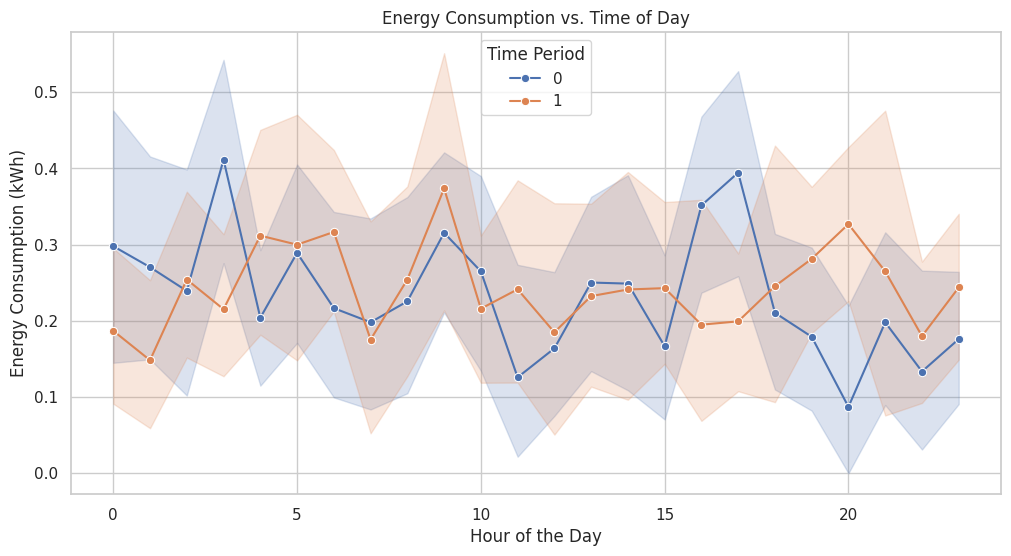

In [ ]:
# Set style
sns.set_theme(style="whitegrid")

# Line plot: Energy Consumption vs. Traffic Count over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="Hour", y="Energy Consumption (kWh)", hue="Day/Night_Night", marker="o")
plt.title("Energy Consumption vs. Time of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.legend(title="Time Period")
plt.grid(True)
plt.show()

<ipython-input-85-523acb07945b>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




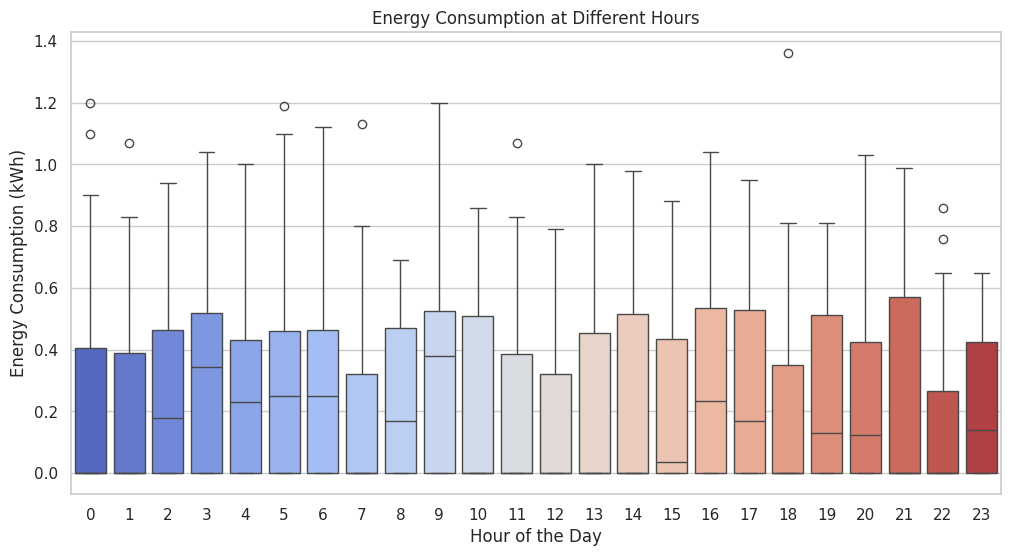

In [ ]:
# Boxplot: Energy Consumption Distribution by Hour
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x="Hour", y="Energy Consumption (kWh)", palette="coolwarm")
plt.title("Energy Consumption at Different Hours")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.show()


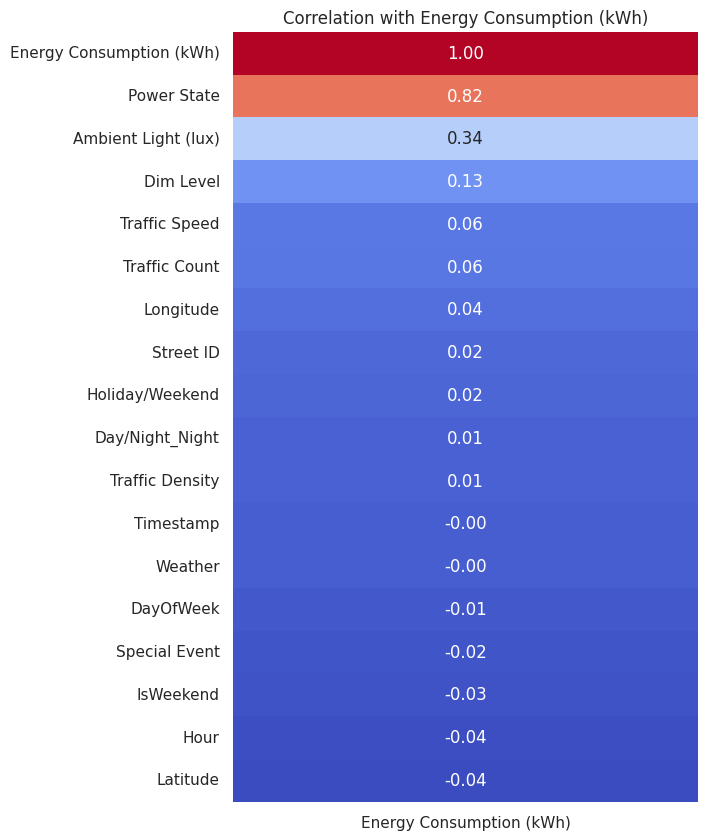

In [ ]:
correlation = data.corr()["Energy Consumption (kWh)"].sort_values(ascending=False)

plt.figure(figsize=(6, 10))
sns.heatmap(correlation.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title('Correlation with Energy Consumption (kWh)')
plt.show()

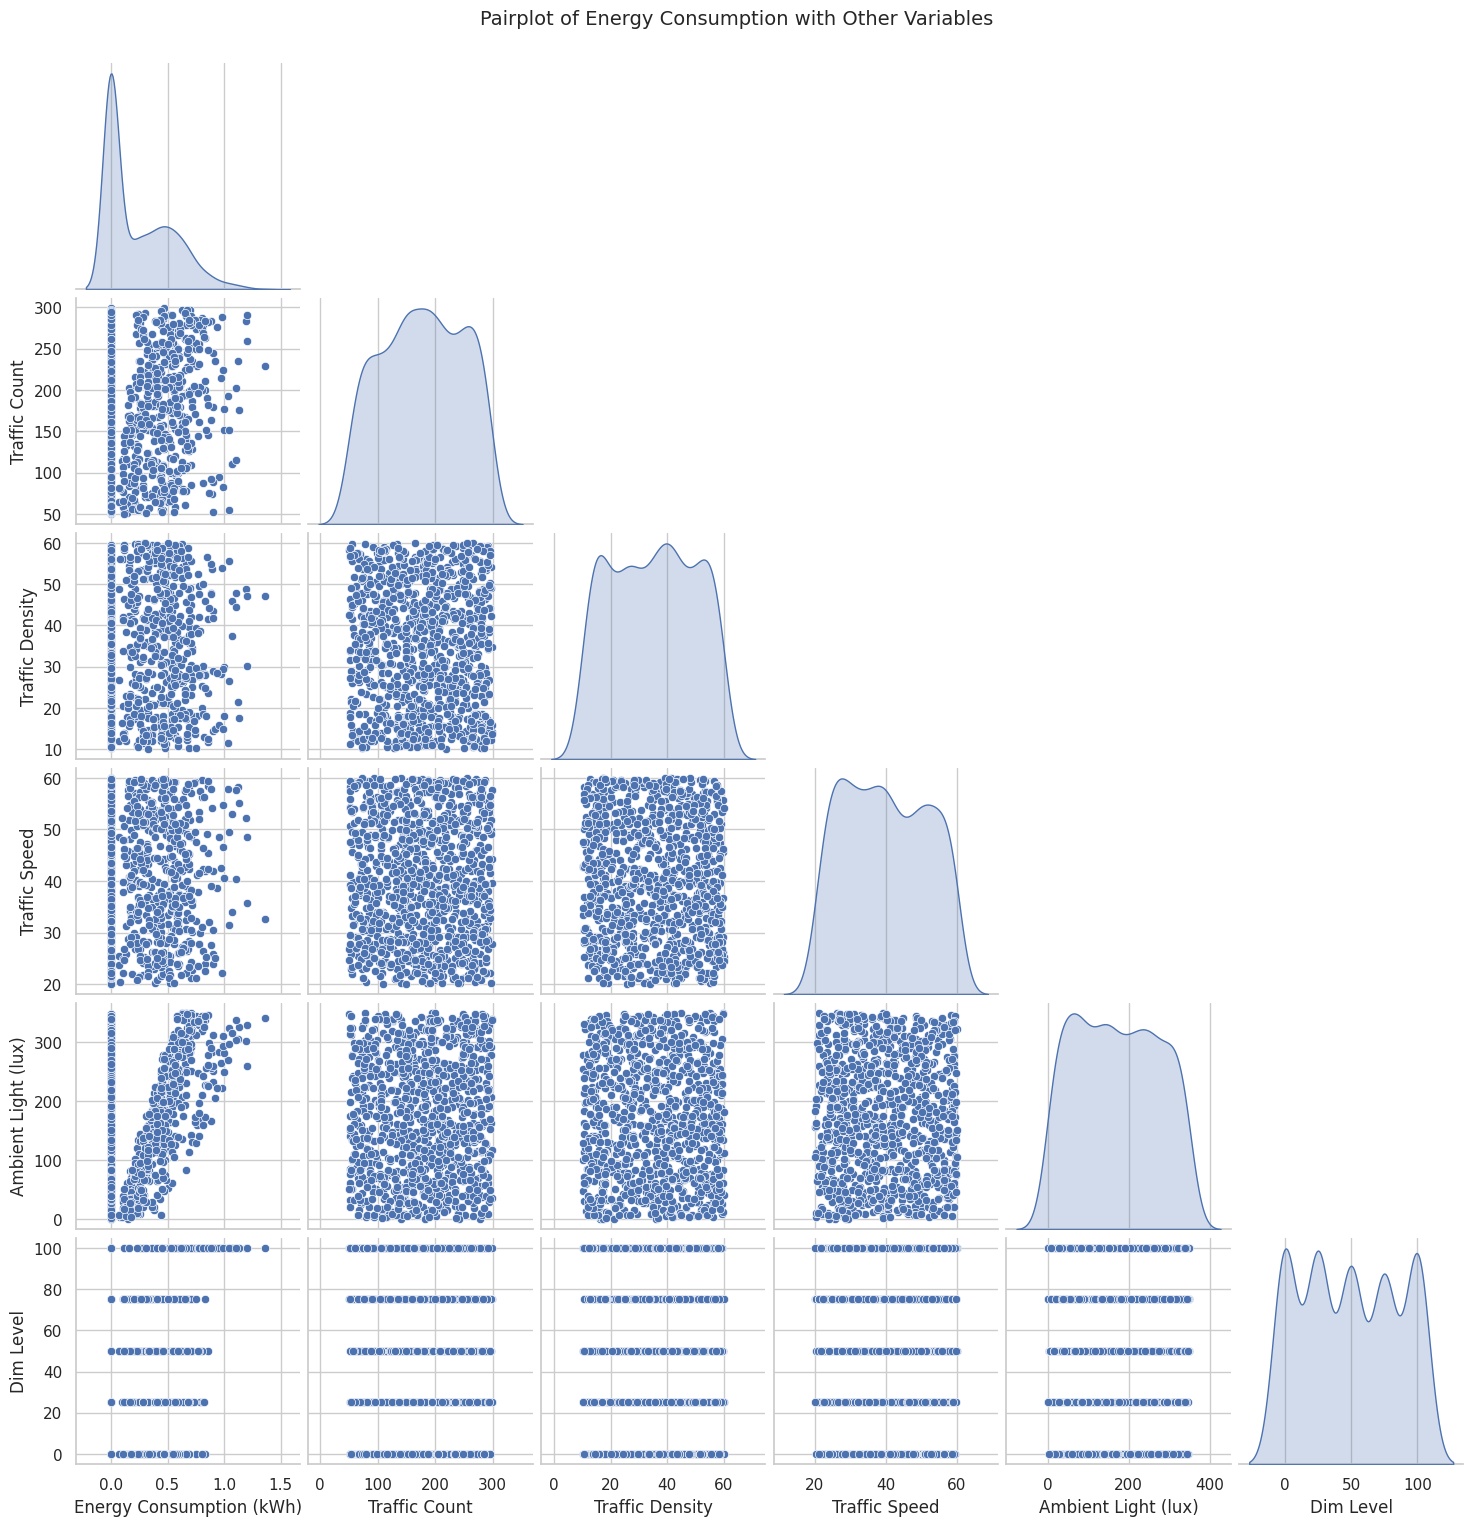

In [ ]:
# Selecting numerical columns for pairplot
num_cols = ["Energy Consumption (kWh)", "Traffic Count", "Traffic Density",
            "Traffic Speed", "Ambient Light (lux)", "Dim Level"]

# Creating pairplot
sns.pairplot(data[num_cols], diag_kind='kde', corner=True)
plt.suptitle("Pairplot of Energy Consumption with Other Variables", fontsize=14, y=1.02)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Selecting variables
x = data["Traffic Density"]
y = data["Ambient Light (lux)"]
z = data["Energy Consumption (kWh)"]

# Creating 3D surface plot
fig = go.Figure(data=[go.Mesh3d(
    x=x, y=y, z=z, opacity=0.5, color='lightblue'
)])

fig.update_layout(
    title="Energy Consumption vs Traffic Density & Ambient Light",
    scene=dict(
        xaxis_title="Traffic Density",
        yaxis_title="Ambient Light (lux)",
        zaxis_title="Energy Consumption (kWh)"
    )
)
fig.show()

In [ ]:
import plotly.express as px

# Map Weather numerical values to meaningful labels (if needed)
weather_mapping = {0: "Clear", 1: "Cloudy", 2: "Rainy", 3: "Snowy"}  # Adjust according to your dataset
data_filtered["Weather_Label"] = data_filtered["Weather"].map(weather_mapping)

# Map Day/Night values to readable labels
data_filtered["Day_Night_Label"] = data_filtered["Day/Night_Night"].map({0: "Day", 1: "Night"})

fig = px.sunburst(
    data_filtered,
    path=['Weather_Label', 'Day_Night_Label', 'Power State'],
    values='Energy Consumption (kWh)',
    color='Energy Consumption (kWh)',
    color_continuous_scale='viridis'
)

fig.update_layout(title="Energy Consumption Breakdown by Weather, Day/Night, and Power State")
fig.show()


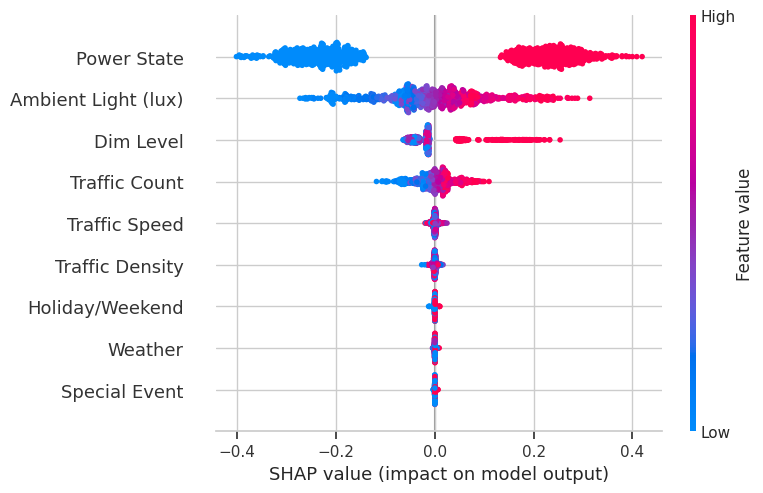

In [ ]:
import shap
import xgboost as xgb

# Selecting important features
features = ["Traffic Count", "Traffic Density", "Traffic Speed", "Ambient Light (lux)",
            "Dim Level", "Weather", "Power State", "Special Event", "Holiday/Weekend"]
X = data[features]
y = data["Energy Consumption (kWh)"]

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X, y)

# SHAP explanation
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Plot feature importance
shap.summary_plot(shap_values, X)


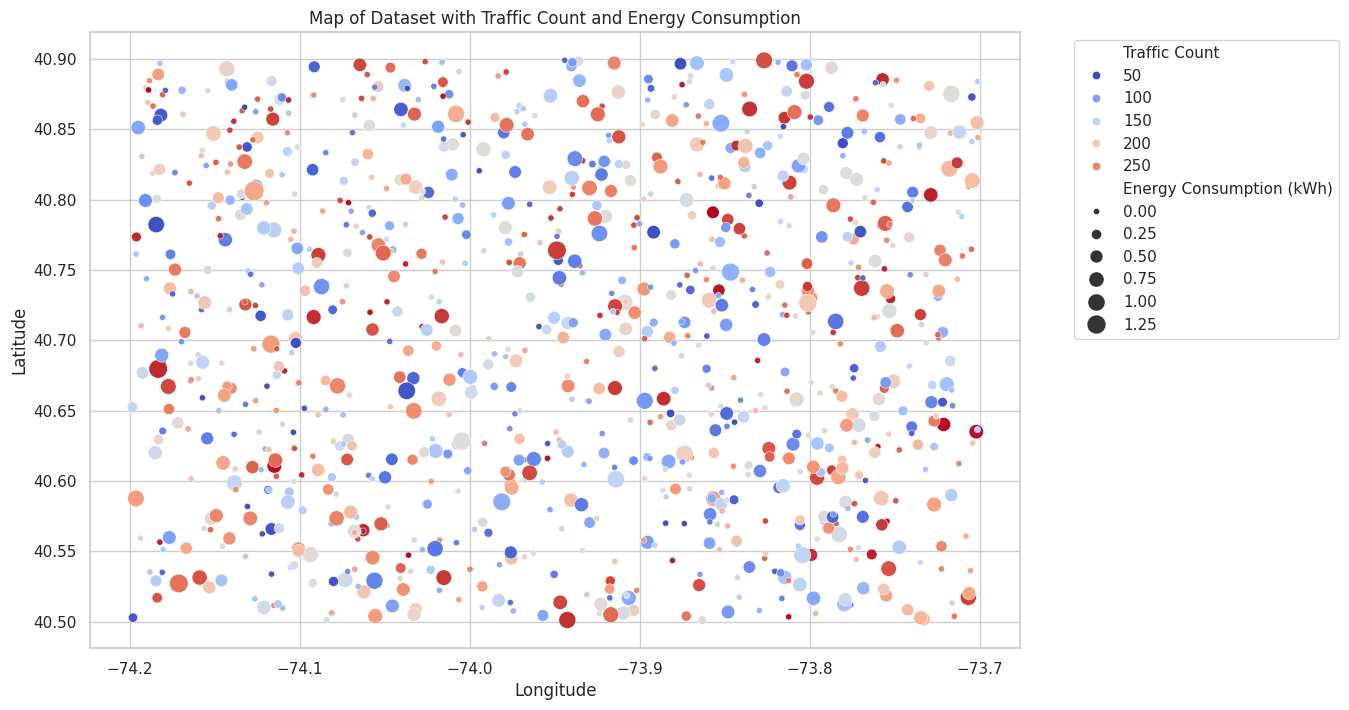

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Longitude',
    y='Latitude',
    hue='Traffic Count',
    size='Energy Consumption (kWh)',
    sizes=(20, 200),
    palette='coolwarm',
    data=data
)
plt.title('Map of Dataset with Traffic Count and Energy Consumption')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
import plotly.express as px

df_cleaned = data.dropna(subset=['Latitude', 'Longitude'])

fig = px.scatter(
    df_cleaned,
    x='Longitude',
    y='Latitude',
    color='Traffic Density',
    size='Energy Consumption (kWh)',
    hover_data=['Street ID', 'Traffic Count', 'Traffic Speed'],
    title='Geospatial Distribution of Dataset'
)

fig.show()

# **Final Pre-processing**

In [ ]:
data = data.drop(columns=['Timestamp', 'Weather', 'Traffic Density', 'DayOfWeek'])
data.dtypes

,0
Street ID,int64
Traffic Count,int64
Traffic Speed,float64
Ambient Light (lux),float64
Energy Consumption (kWh),float64
Power State,int64
Dim Level,int64
Latitude,float64
Longitude,float64
Special Event,int64


In [ ]:
data.head()

,Street ID,Traffic Count,Traffic Speed,Ambient Light (lux),Energy Consumption (kWh),Power State,Dim Level,Latitude,Longitude,Special Event,Holiday/Weekend,Hour,IsWeekend,Day/Night_Night
0,8,154,59.383884,172.439065,0.37,1,50,40.877092,-73.813538,1,0,5,True,0
1,3,103,24.208586,189.339042,0.00,0,100,40.862553,-74.125943,0,0,12,False,1
2,9,203,29.733312,200.236036,0.00,0,75,40.809826,-73.853724,1,0,20,False,1
3,5,161,27.850047,197.078404,0.78,1,100,40.529601,-74.073302,0,0,13,False,0
4,1,55,59.282133,279.109775,0.46,1,50,40.565817,-74.116742,1,1,7,False,1


## **Machine learning**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = data.drop(columns=['Energy Consumption (kWh)'])
y = data['Energy Consumption (kWh)']

columns_to_scale = ['Traffic Count', 'Traffic Speed', 'Ambient Light (lux)', 'Dim Level', 'Latitude', 'Longitude']

scaler = StandardScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [ ]:
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (800, 6)
Test features shape: (200, 6)


In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Performance Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

Random Forest Results:
RMSE: 0.28116211160111887
MAE: 0.24455000000000002
R²: 0.06881341494454074


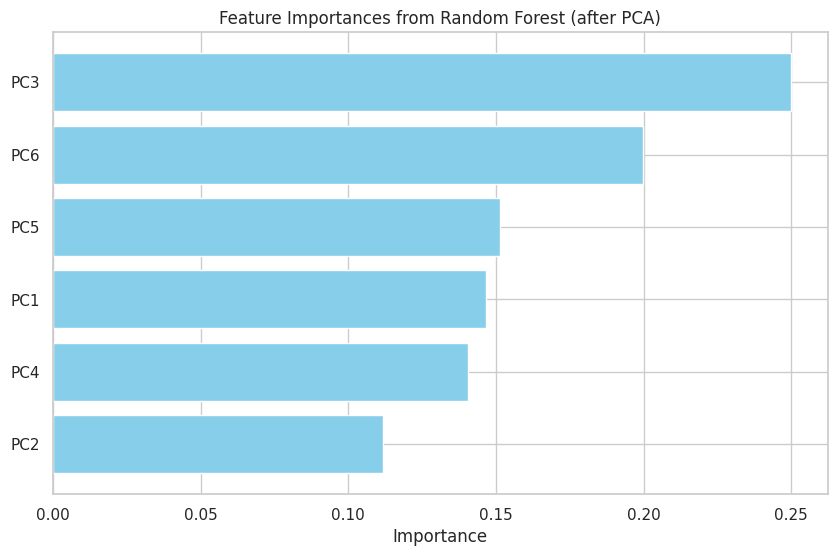

In [ ]:
print(f"Random Forest Results:\nRMSE: {rmse_rf}\nMAE: {mae_rf}\nR²: {r2_rf}")

# Feature Importance Plot
feature_importances = pd.DataFrame({
    'Feature': ['PC' + str(i+1) for i in range(X_pca.shape[1])],
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest (after PCA)')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import xgboost as xgb

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Performance Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [ ]:
print(f"\nXGBoost Results:\nRMSE: {rmse_xgb}\nMAE: {mae_xgb}\nR²: {r2_xgb}")


XGBoost Results:
RMSE: 0.2818132266692634
MAE: 0.23439396209758706
R²: 0.06449553826428267


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape for LSTM (samples, time steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train Model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test), verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0938 - val_loss: 0.0784
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0836 - val_loss: 0.0879
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0808 - val_loss: 0.0761
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0794 - val_loss: 0.0764
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0807 - val_loss: 0.0756
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0815 - val_loss: 0.0771
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0807 - val_loss: 0.0759
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0778 - val_loss: 0.0760
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0776 - val_loss: 0.0759
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0867 - val_loss: 0.0764
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0855 - val_loss: 0.0791
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0739 - val_loss: 0.

In [ ]:
# Predictions
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Performance Metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"\nLSTM Results:\nRMSE: {rmse_lstm}\nMAE: {mae_lstm}\nR²: {r2_lstm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

LSTM Results:
RMSE: 0.27853024105117913
MAE: 0.24216632482707504
R²: 0.08616491458386522


In [ ]:
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'RMSE': [rmse_rf, rmse_xgb, rmse_lstm],
    'MAE': [mae_rf, mae_xgb, mae_lstm],
    'R²': [r2_rf, r2_xgb, r2_lstm]
})

print("\nModel Performance Comparison:\n")
print(results_df)


Model Performance Comparison:

           Model      RMSE       MAE        R²
0  Random Forest  0.281162  0.244550  0.068813
1        XGBoost  0.281813  0.234394  0.064496
2           LSTM  0.278530  0.242166  0.086165


# **Fine-Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

rf_tuned = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1)
rf_tuned.fit(X_train, y_train)

# Best Model
best_rf = rf_tuned.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

# Performance
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f"\n🔹 Tuned Random Forest:\nRMSE: {rmse_rf_tuned}\nMAE: {mae_rf_tuned}\nR²: {r2_rf_tuned}")



🔹 Tuned Random Forest:
RMSE: 0.2762338629506262
MAE: 0.24094523734366238
R²: 0.10117125751793965


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_tuned = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_tuned.fit(X_train, y_train)

# Best Model
best_xgb = xgb_tuned.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test)

# Performance
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)

print(f"\n🔹 Tuned XGBoost:\nRMSE: {rmse_xgb_tuned}\nMAE: {mae_xgb_tuned}\nR²: {r2_xgb_tuned}")



🔹 Tuned XGBoost:
RMSE: 0.2764428757371245
MAE: 0.24505616150796414
R²: 0.09981054255808386


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Reshape data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build an improved LSTM model
lstm_model_tuned = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

lstm_model_tuned.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
lstm_model_tuned.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test), callbacks=[early_stop], verbose=1)

# Predictions
y_pred_lstm_tuned = lstm_model_tuned.predict(X_test_lstm).flatten()

# Performance
rmse_lstm_tuned = np.sqrt(mean_squared_error(y_test, y_pred_lstm_tuned))
mae_lstm_tuned = mean_absolute_error(y_test, y_pred_lstm_tuned)
r2_lstm_tuned = r2_score(y_test, y_pred_lstm_tuned)

print(f"\n🔹 Tuned LSTM:\nRMSE: {rmse_lstm_tuned}\nMAE: {mae_lstm_tuned}\nR²: {r2_lstm_tuned}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.1038 - val_loss: 0.0897
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0865 - val_loss: 0.0819
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0907 - val_loss: 0.0836
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0843 - val_loss: 0.0948
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0887 - val_loss: 0.0821
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0853 - val_loss: 0.0791
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0789 - val_loss: 0.0814
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0821 - val_loss: 0.0807
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0811 - val_loss: 0.0781
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0816 - val_loss: 0.0800
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0804 - val_loss: 0.0797
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/ste

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

🔹 Tuned LSTM:
RMSE: 0.2769356239569422
MAE: 0.24316010760366916
R²: 0.09659858007688593


In [ ]:
results_tuned = pd.DataFrame({
    'Model': ['Random Forest (Tuned)', 'XGBoost (Tuned)', 'LSTM (Tuned)'],
    'RMSE': [rmse_rf_tuned, rmse_xgb_tuned, rmse_lstm_tuned],
    'MAE': [mae_rf_tuned, mae_xgb_tuned, mae_lstm_tuned],
    'R²': [r2_rf_tuned, r2_xgb_tuned, r2_lstm_tuned]
})

print("\n🚀 Model Performance After Fine-Tuning:\n")
print(results_tuned)



🚀 Model Performance After Fine-Tuning:

                   Model      RMSE       MAE        R²
0  Random Forest (Tuned)  0.276234  0.240945  0.101171
1        XGBoost (Tuned)  0.276443  0.245056  0.099811
2           LSTM (Tuned)  0.276936  0.243160  0.096599


# **Develop a Visualization Dashboard for Urban Planners**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Correlation Matrix
corr_matrix = data.corr()

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['Energy Consumption (kWh)']].sort_values(by="Energy Consumption (kWh)", ascending=False),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("🔍 Sensitivity Analysis: Factors Influencing Energy Consumption")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.

